# The Future is Green

> *At a nursery* <br>
> Thats a moneyplant init? Actually sir those are weeds.

<a id = 'toc'></a>
## Table of Contents
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;[Before the Beginning](#begin)
1. [Introduction](#intro)
2. [Importing the essential libraries](#import)
3. [Examining the Data](#load)
4. [Identify Unbalanced Classes](#identify)<br>
 [Fake It Till You Make it](#making)
5. [Data Normalisation and Augmentation](#augmentation)
6. [Resize and Normalise Data](#normalise)
7. [Data Augmentation](#data_augmentation)<br>
[The Models](#models)
8. [Defining the Models](#model)<br>
[Saving Rose](#save)

<a id = 'begin'></a>
# [Before the Beginning](#toc)

>In the beginning God created the heavens and the earth. Now the earth was formless and empty, darkness was over the surface of the deep, and the Spirit of God was hovering over the waters. And God said, “Let there be light,” and there was light.

<a id = 'intro'></a>
## [1. Introduction](#toc)

In this notebook we'll be using some well-known architectures to learn to recognise the species of plant from the image of its sapling. This seems pretty legit doesn't it? We've moved to classifying things even humans have difficulties in recognising. 

<a id = 'import'></a>
## [2. Importing the Essential Libraries](#toc)

> Sumerians invented the wheel. I'd much rather just use it. 

In [1]:
import numpy as np
import itertools
import os
import PIL
import pathlib
import math
import random
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import HTML, display
import tabulate
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

!/usr/local/cuda/bin/nvcc --version

!nvidia-smi 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Thu Oct  7 16:34:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |            

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = 'load'></a>
## [3. Examining the Data](#toc)

> Getting a piece of the pie? Here's some more.


After running the script in the folder, we have balanced the data


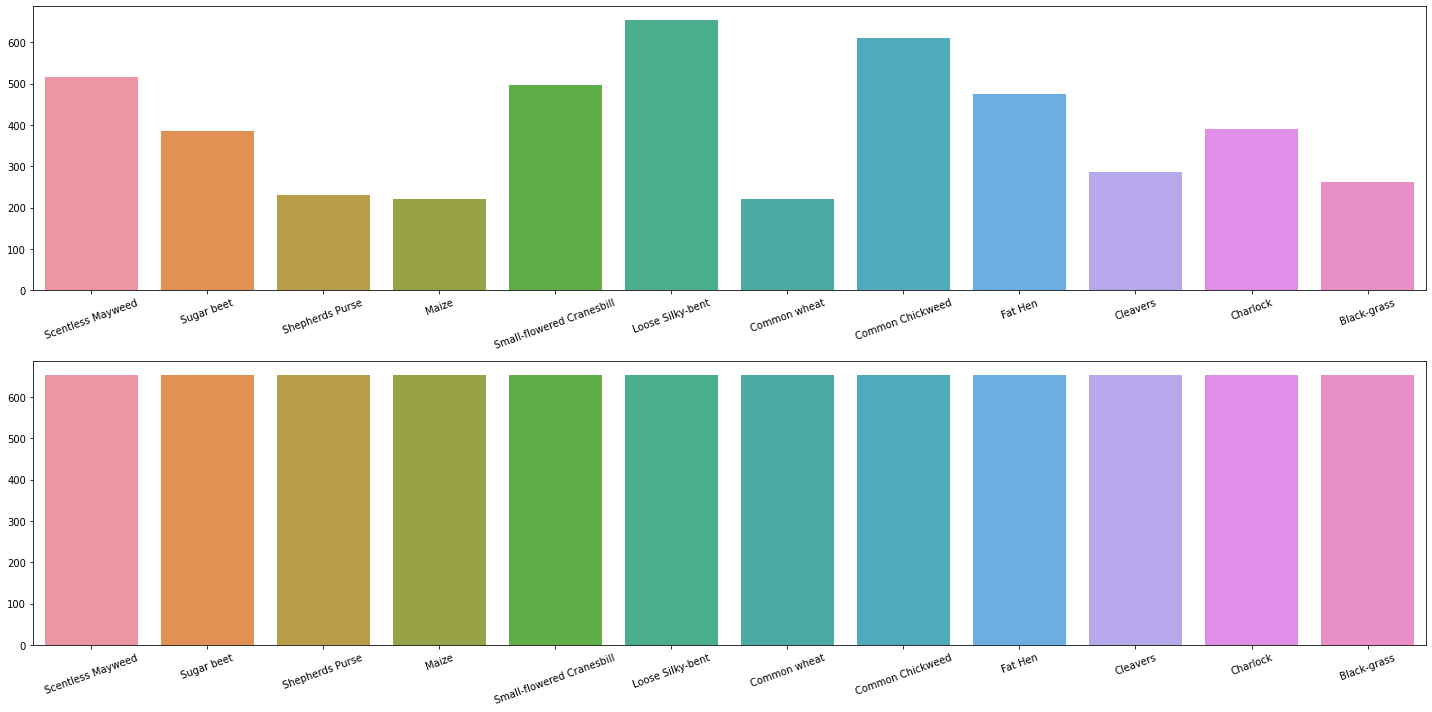

In [3]:
training_images = '/content/drive/MyDrive/Assignments/Week 3/Data/train'
categories = [category for category in os.listdir(training_images)]
distribution_old = [len(os.listdir(os.path.join(training_images, category))) for category in categories]


training_images_updated = '/content/drive/MyDrive/Assignments/Week 3/Data/train_updated'
distribution_new = [len(os.listdir(os.path.join(training_images_updated, category))) for category in categories]

plt.figure(figsize=(20, 10));
plt.subplot(2,1,1);
sns.barplot(x = categories, y = distribution_old);
plt.xticks(rotation = 20);

print('After running the script in the folder, we have balanced the data')

plt.subplot(2,1,2);
sns.barplot(x = categories, y = distribution_new);
plt.xticks(rotation = 20);
plt.tight_layout()

So we can see that the dataset is more or less balanced. This has been achieved only after augmentation by another script.

<a id = 'making'></a>
# [Fake It Till You Make it](#toc)

> `Lying for the 'greater good'`

<a id = 'augmentation'></a>
## [Data Normalisation and Augmentation](#toc)

> Want some data? Make your own!

<a id = 'normalise'></a>
## [Load Data](#toc)

Before augmentation, we need to convert all images to a uniform size and also normalise the images by rescaling to a value between 0 and 1.

In [4]:
def prepare_data(cnn_model = 'inception', IMG_SHAPE = (400,400)):
  """
  """
  from keras_preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications import inception_v3
  from tensorflow.keras.applications import resnet50
  from tensorflow.keras.applications import vgg16

  if cnn_model == 'inception':
    datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
  elif cnn_model == 'resnet':
    datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
  elif cnn_model == 'vgg16':
    datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
    
  train_ds = datagen.flow_from_directory(directory = '/content/drive/MyDrive/Assignments/Week 3/Data/train_updated',
                                         target_size = IMG_SHAPE,
                                         subset = 'training',
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         shuffle = True,
                                         seed = 123)
  val_ds = datagen.flow_from_directory(directory = '/content/drive/MyDrive/Assignments/Week 3/Data/train_updated',
                                       target_size = IMG_SHAPE,
                                        subset = 'validation',
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        shuffle = True,
                                        seed = 123)
  return train_ds, val_ds

<a id = 'models'></a>
# [The Models](#toc)
> One man's meat is another's poison

<a id = 'model'></a>
## [Defining the Models](#toc)

In this section we will define and run our CNN architecture with the aim to do a comparative study of the models on our data and observe which one performs the best.

In [5]:
def VGG16(num_per_class, optimizer, loss, metrics, epochs):
  """
  Implements a tweaked version of the VGG-16 neural network

  Arguments:-
  1) Number of Images for each class
  2) Optimizer for learning rate
  3) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
  4) Metrics to judge model performance
  5) Number of epochs

  Returns:-
  Trained model implementing VGG-16 Neural Network with a few modifications (such as classes in the final activation function)
  """
  train_ds, val_ds = prepare_data(cnn_model = 'vgg16')
  rescale = keras.layers.experimental.preprocessing.Rescaling(1./255)
  vgg16_model=keras.applications.VGG16(include_top=False,
                                       weights='imagenet')
  for layer in vgg16_model.layers[0:-6]:
    layer.trainable = False
  
  prediction_layer = keras.Sequential([keras.layers.Flatten(),
                                      #  keras.layers.Dense(1024),
                                      #  keras.layers.BatchNormalization(),
                                      #  keras.layers.Activation('relu'),
                                      #  keras.layers.Dropout(0.2),
                                       keras.layers.Dense(128),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.Activation('relu'),
                                       keras.layers.Dropout(0.2),
                                       keras.layers.Dense(len(num_per_class),activation='softmax')])
  
  model = tf.keras.Sequential([rescale,
                              vgg16_model,
                              prediction_layer
                              ])

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)
  checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Assignments/Week 3/Saved_Model/model_vgg16.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
  history = model.fit(train_ds, validation_data=val_ds, epochs = epochs, verbose = 1, callbacks = [reduce_lr, early_stop])
  return train_ds, val_ds, model, history

def ResNet(num_per_class, optimizer, loss, metrics, epochs):
  '''
  Implements a version of the ResNet neural network

  Arguments:-
  1) Number of Images for each class
  2) Optimizer for learning rate
  3) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
  4) Metrics to judge model performance
  5) Number of epochs

  Returns:-
  Trained model implementing ResNet Neural Network with a few modifications (such as output of neural network has fewer classes than the original ResNet)
  '''
  train_ds, val_ds = prepare_data(cnn_model = 'resnet')
  rescale = keras.layers.experimental.preprocessing.Rescaling(1./255)
  resnet_model = keras.applications.resnet50.ResNet50(include_top=False,
                                                      weights='imagenet')


  for layer in resnet_model.layers[0:-6]:
    layer.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = keras.Sequential([keras.layers.Flatten(),
                                      #  keras.layers.Dense(1024),
                                      #  keras.layers.BatchNormalization(),
                                      #  keras.layers.Activation('relu'),
                                      #  keras.layers.Dropout(0.2),
                                       keras.layers.Dense(128),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.Activation('relu'),
                                       keras.layers.Dropout(0.2),
                                       keras.layers.Dense(len(num_per_class),activation='softmax')])

  model = keras.Sequential([rescale,
                              resnet_model,
                              prediction_layer
                              ])

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)
  checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Assignments/Week 3/Saved_Model/model_resnet50.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

  history = model.fit(train_ds, validation_data=val_ds, epochs = epochs, verbose = 1, callbacks = [reduce_lr, early_stop])
  return train_ds, val_ds, model, history
  
def Inception(num_per_class, optimizer, loss, metrics, epochs):
  '''
  We need to go deeper
  Implements a version of the Inception neural network

  Arguments:-
  1) Number of Images for each class
  2) Optimizer for learning rate
  3) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
  4) Metrics to judge model performance
  5) Number of epochs

  Returns:-
  Trained model implementing Inception Neural Network with a few modifications (such as output of neural network has fewer classes than the original ResNet)
  '''
  train_ds, val_ds = prepare_data(cnn_model = 'inception')
  rescale = keras.layers.experimental.preprocessing.Rescaling(1./255)
  inception_model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                                weights='imagenet')

  for layer in inception_model.layers[0:-3]:
    layer.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = keras.Sequential([keras.layers.Flatten(),
                                      #  keras.layers.Dense(1024),
                                      #  keras.layers.BatchNormalization(),
                                      #  keras.layers.Activation('relu'),
                                      #  keras.layers.Dropout(0.2),
                                       keras.layers.Dense(128),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.Activation('relu'),
                                       keras.layers.Dropout(0.2),
                                       keras.layers.Dense(len(num_per_class),activation='softmax')])

  model = tf.keras.Sequential([rescale,
                              inception_model,
                              prediction_layer
                              ])

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)
  checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Assignments/Week 3/Saved_Model/model_inceptionv3.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

  history = model.fit(train_ds, validation_data=val_ds, epochs = epochs, verbose = 1, callbacks = [reduce_lr, early_stop])
  return train_ds, val_ds, model, history

def implement_cnn(num_per_class, cnn_model, optimizer, loss, metrics, epochs):
  """
  Implements CNN based on choice of architecture
  Arguments:-
  1) Number of Images for each class
  2) Choice of CNN architecture
  3) Optimizer for learning rate
  4) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
  5) Metrics to judge model performance
  6) Number of epochs

  Returns:-
  Trained model implementing CNN architecture as per choice
  """
  if cnn_model == "vgg16":
    train_ds, val_ds, model, history = VGG16(num_per_class, optimizer, loss, metrics, epochs)

  elif cnn_model == "resnet":
    train_ds, val_ds, model, history = ResNet(num_per_class, optimizer, loss, metrics, epochs)

  elif cnn_model == "inception":
    train_ds, val_ds, model, history = Inception(num_per_class, optimizer, loss, metrics, epochs)
  
  return train_ds, val_ds, model, history

In [6]:
print('Training the VGG Model')
vgg16_model, vgg16_history = implement_cnn(num_per_class = distribution_new, cnn_model = "vgg16", optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'], epochs = 10)
print('------------------------------------------------------Trained------------------------------------------------------')

Training the VGG Model
Found 6288 images belonging to 12 classes.
Found 1560 images belonging to 12 classes.
58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/10
197/197 [==============================] - 1997s 10s/step - loss: 1.8103 - accuracy: 0.3723 - val_loss: 3.6697 - val_accuracy: 0.2692
Epoch 2/10
197/197 [==============================] - 422s 2s/step - loss: 1.0373 - accuracy: 0.6419 - val_loss: 1.6488 - val_accuracy: 0.5346
Epoch 3/10
197/197 [==============================] - 419s 2s/step - loss: 0.7807 - accuracy: 0.7352 - val_loss: 2.8840 - val_accuracy: 0.3558
Epoch 4/10
197/197 [==============================] - 415s 2s/step - loss: 0.5863 - accuracy: 0.8122 - val_loss: 0.5676 - val_accuracy: 0.8128
Epoch 5/10
197/197 [==============================] - 413s 2s/step - loss: 0.5017 - accuracy: 0.8362 - val_loss: 0.5253 - val_accuracy: 0.8077
Epoch 6/10
197/197 [==============================] - 410s 2s/step - loss: 0.4591 - accuracy: 0.8542 - val_lo

In [20]:
print('Training the ResNet Model')
resnet_train_ds, resnet_val_ds, resnet_model, resnet_history = implement_cnn(num_per_class = distribution_new, cnn_model = "resnet", optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'], epochs = 10)
print('------------------------------------------------------Trained------------------------------------------------------')

Training the ResNet Model
Found 6288 images belonging to 12 classes.
Found 1560 images belonging to 12 classes.
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
197/197 [==============================] - 389s 2s/step - loss: 21.5351 - accuracy: 0.0913 - val_loss: 10.9957 - val_accuracy: 0.0987
Epoch 2/10
197/197 [==============================] - 381s 2s/step - loss: 8.3558 - accuracy: 0.1115 - val_loss: 6.0582 - val_accuracy: 0.1115
Epoch 3/10
197/197 [==============================] - 382s 2s/step - loss: 7.7382 - accuracy: 0.1161 - val_loss: 4.4676 - val_accuracy: 0.1564
Epoch 4/10
197/197 [==============================] - 379s 2s/step - loss: 6.6383 - accuracy: 0.1285 - val_loss: 9.5927 - val_accuracy: 0.1429
Epoch 5/10
197/197 [==============================] - 376s 2s/step - loss: 2.8123 - accuracy: 0.1826 - val_loss: 2.3964 - val_accuracy: 0.1981
Epoch 6/10
197/197 [==============================] - 377s 2s/step - loss: 2.3767 - accuracy: 0.2024 - val

In [ ]:
print('Training the Inception Model')
inception_train_ds, inception_val_ds, inception_model, inception_history = implement_cnn(num_per_class = distribution_new, cnn_model = "inception", optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'], epochs = 10)
print('------------------------------------------------------Trained------------------------------------------------------')

Training the Inception Model
Found 6288 images belonging to 12 classes.
Found 1560 images belonging to 12 classes.
87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/10
172/197 [=========================>....] - ETA: 36s - loss: 13.3031 - accuracy: 0.1475

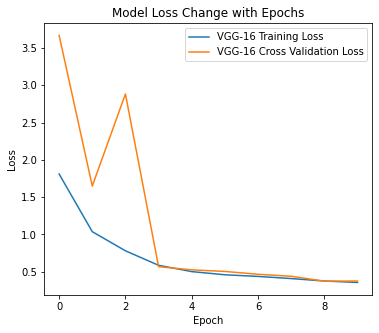

In [7]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss Change with Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['VGG-16 Training Loss', 'VGG-16 Cross Validation Loss'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model Loss Change with Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet Training Loss','ResNet Cross Validation Loss'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Model Loss Change with Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Inception Training Loss','Inception Cross Validation Loss'], loc='upper right')
plt.show()

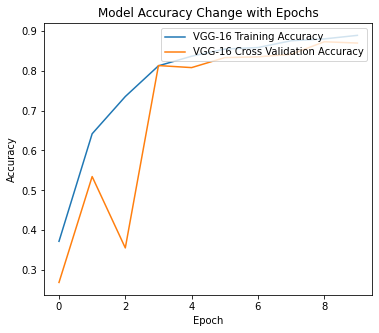

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy Change with Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG-16 Training Accuracy', 'VGG-16 Cross Validation Accuracy'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy Change with Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet Training Accuracy','ResNet Cross Validation Accuracy'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Model Accuracy Change with Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Inception Training Accuracy','Inception Cross Validation Accuracy'], loc='upper right')
plt.show()

In [26]:
def get_labels(val_ds):
  """
  Get the labels of all examples in the validation set
  Arguments:
  1) Cross Validation Dataset
  Returns:-
  1) Numpy array with true label values
  """
  labels = []
  i = 0
  for _, labels_batch in tqdm(val_ds):
        labels.extend(labels_batch)
        i+=1
        if i >=49:
          break
  
  return np.array(labels)

In [21]:
train_ds, val_ds = prepare_data(cnn_model = 'vgg16')
labels = get_labels(val_ds)

Found 6288 images belonging to 12 classes.
Found 1560 images belonging to 12 classes.


 98%|█████████▊| 48/49 [01:02<00:01,  1.31s/it]


In [25]:
labels = np.array(labels)

In [28]:
def get_classification_report(model, val_ds, labels):
  """
  """
  from sklearn.metrics import classification_report
  y_pred = model.predict(val_ds)
  labels = np.argmax(labels, axis = 1)
  y_pred_bool = np.argmax(y_pred, axis = 1)
  print(classification_report(labels, y_pred_bool))
  return

def get_confusion_matrix(model, val_ds, labels):
  """
  """
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  y_pred = model.predict(val_ds)
  labels = np.argmax(labels, axis = 1)
  y_pred_bool = np.argmax(y_pred, axis = 1)
  conf_matrix = confusion_matrix(labels, y_pred_bool)
  plt.figure(figsize=(20, 5))
  sns.heatmap(conf_matrix, annot=True, cmap='Blues')
  plt.show()
  return

In [32]:
print("Classification Report for VGG-16 Model")
get_classification_report(vgg16_model, val_ds, labels)

print("Classification Report for ResNet Model")
get_classification_report(resnet_model, val_ds, labels)

print("Classification Report for Inception-V3 Model")
get_classification_report(inception_model, val_ds, labels)

In [31]:
print("Confusion Matrix for VGG-16 Model")
get_confusion_matrix(vgg16_model, val_ds, labels)

print("Confusion Matrix for ResNet Model")
get_confusion_matrix(resnet_model, val_ds, labels)

print("Confusion Matrix for Inception-V3 Model")
get_confusion_matrix(inception_model, val_ds, labels)

<a id = 'save'></a>
# [Saving Rose](#toc)

> `Survival of the fittest.`

In [ ]:
!mkdir -p '/content/drive/MyDrive/Assignments/Week 3/Saved_Model'
# Take the model with the best accuracy and save it to the folder created

inception_model.save('/content/drive/MyDrive/Assignments/Week 3/Saved_Model/my_model')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Assignments/Week 3/Saved_Model/my_model')
new_model.summary()